# Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import model_to_dot

In [2]:
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [3]:
train['played'] = 1

In [4]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 50)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 50)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,2551,1003
1,2858,761
2,227,749
3,2478,346
4,693,746
...,...,...
1994645,3386,911
1994646,842,74
1994647,3084,402
1994648,2102,226


In [5]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
61093,892,1076,0
1334300,84,2035,0
1434598,166,1447,0
1507990,796,2541,0
1684000,79,3378,0
...,...,...,...
1382983,85,2389,0
190841,207,2919,0
1788463,359,2953,0
681368,615,985,0


In [6]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.9741918329666291
0.025808167033370834


In [7]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [65]:
n_latent_factors = 128
n_epochs = 50

### Multi-Layer Perceptron part of model

In [66]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='MLP-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='MLP-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='MLP-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='MLP-Flatten-Users')(user_embedding)

mlp_layer = keras.layers.concatenate([game_vec, user_vec], name="MLP-User-Games")

for i in [4, 2, 1, 0.5, 0.25, 0]:
  mlp_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  mlp_layer = Dense(math.floor(n_latent_factors * i), activation='relu', 
              kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  if i == 4:
    mlp_layer = BatchNormalization()(mlp_layer)
  mlp_layer = Dropout(0.2)(mlp_layer)

mlp = Model(inputs=[user_input, game_input], outputs=mlp_output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [67]:
# train mlp weights
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 1545751 samples
Epoch 1/50
1545751/1545751 [==============================] - 102s 66us/sample - loss: 0.1321 - binary_accuracy: 0.9740
Epoch 2/50
1545751/1545751 [==============================] - 85s 55us/sample - loss: 0.1006 - binary_accuracy: 0.9742
Epoch 3/50
1545751/1545751 [==============================] - 99s 64us/sample - loss: 0.0980 - binary_accuracy: 0.9742
Epoch 4/50
1545751/1545751 [==============================] - 89s 58us/sample - loss: 0.0974 - binary_accuracy: 0.9742
Epoch 5/50
1545751/1545751 [==============================] - 91s 59us/sample - loss: 0.0970 - binary_accuracy: 0.9742
Epoch 6/50
1545751/1545751 [==============================] - 91s 59us/sample - loss: 0.0968 - binary_accuracy: 0.9742
Epoch 7/50
1545751/1545751 [==============================] - 100s 65us/sample - loss: 0.0968 - binary_accuracy: 0.9742
Epoch 8/50
1545751/1545751 [==============================] - 101s 65us/sample - loss: 0.0970 - binary_accuracy: 0.9742
Epoch 9/50
1545751/1

Text(0, 0.5, 'Training Error')

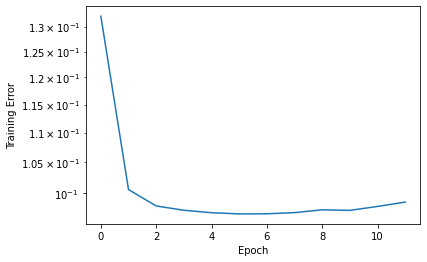

In [68]:
pd.Series(mlp_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [69]:
# lock mlp weights
mlp.trainable = False
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Generalized Matrix Factorization part of model

In [70]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='GMF-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='GMF-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='GMF-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='GMF-Flatten-Users')(user_embedding)

prod = keras.layers.dot([user_vec, game_vec], axes=1, name='Dot-Product')

gmf = Model(inputs=[user_input, game_input], outputs=prod)
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [71]:
# train gmf weights
gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs)

Train on 1545751 samples
Epoch 1/50
1545751/1545751 [==============================] - 31s 20us/sample - loss: 0.0231 - mae: 0.0392 - mse: 0.0228
Epoch 2/50
1545751/1545751 [==============================] - 30s 20us/sample - loss: 0.0219 - mae: 0.0423 - mse: 0.0215
Epoch 3/50
1545751/1545751 [==============================] - 30s 19us/sample - loss: 0.0210 - mae: 0.0431 - mse: 0.0205
Epoch 4/50
1545751/1545751 [==============================] - 30s 20us/sample - loss: 0.0204 - mae: 0.0430 - mse: 0.0198
Epoch 5/50
1545751/1545751 [==============================] - 30s 19us/sample - loss: 0.0200 - mae: 0.0427 - mse: 0.0192
Epoch 6/50
1545751/1545751 [==============================] - 30s 19us/sample - loss: 0.0196 - mae: 0.0424 - mse: 0.0188
Epoch 7/50
1545751/1545751 [==============================] - 30s 19us/sample - loss: 0.0194 - mae: 0.0421 - mse: 0.0184
Epoch 8/50
1545751/1545751 [==============================] - 30s 20us/sample - loss: 0.0192 - mae: 0.0418 - mse: 0.0182
Epoch 9

Text(0, 0.5, 'Training Error')

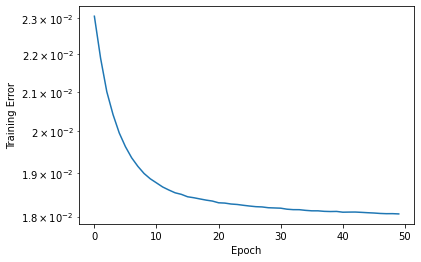

In [72]:
pd.Series(gmf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [73]:
# lock gmf weights
gmf.trainable = False
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [74]:
# Combining MLP and GMF parts of the model
mlp_gmf = Concatenate()([mlp.output, gmf.output])
ncf_output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='NCF-Output')(mlp_gmf)
ncf = Model([mlp.input, gmf.input], ncf_output)
ncf.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [75]:
ncf.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MLP-Game (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-User (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-Game-Embedding (Embedding)  (None, 1, 64)        66112       MLP-Game[0][0]                   
__________________________________________________________________________________________________
MLP-User-Embedding (Embedding)  (None, 1, 64)        218048      MLP-User[0][0]                   
___________________________________________________________________________________________

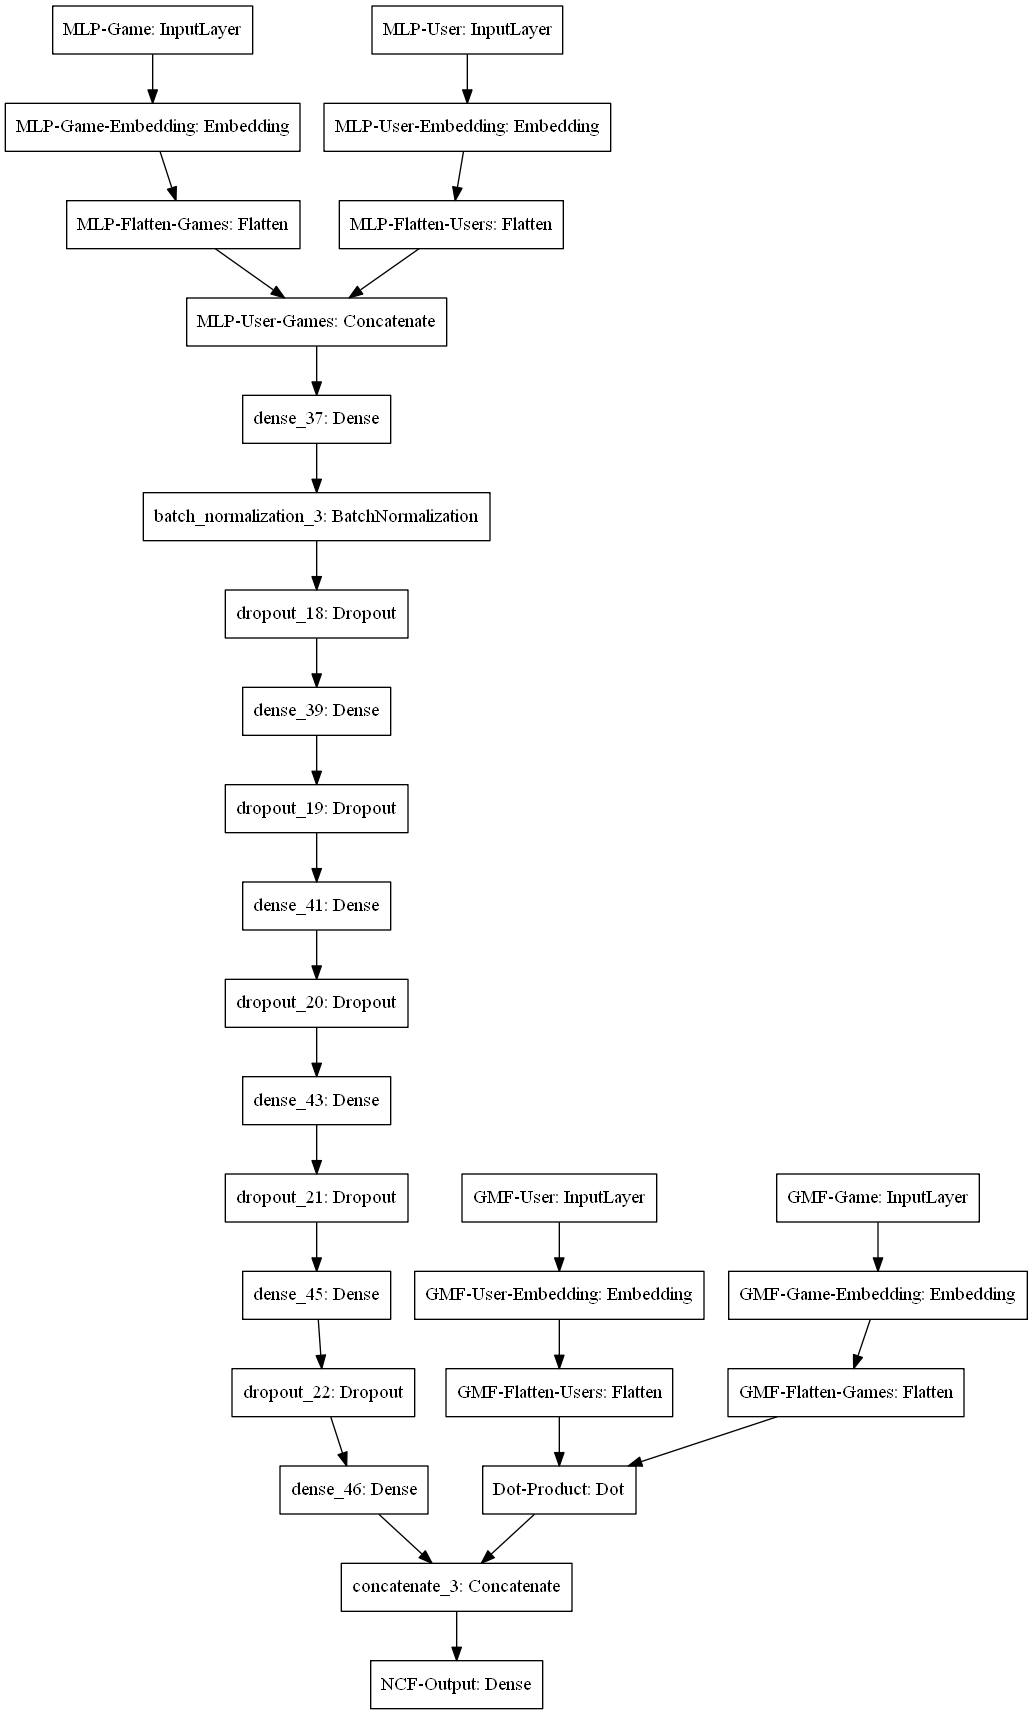

In [76]:
plot_model(ncf)

## Model Training

In [77]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([train.user_id, train.game_id, train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 1545751 samples
Epoch 1/50
1545751/1545751 [==============================] - 41s 27us/sample - loss: 0.1839 - binary_accuracy: 0.9742
Epoch 2/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1416 - binary_accuracy: 0.9742
Epoch 3/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1362 - binary_accuracy: 0.9742
Epoch 4/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1312 - binary_accuracy: 0.9742
Epoch 5/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1263 - binary_accuracy: 0.9742
Epoch 6/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1215 - binary_accuracy: 0.9742
Epoch 7/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1170 - binary_accuracy: 0.9742
Epoch 8/50
1545751/1545751 [==============================] - 40s 26us/sample - loss: 0.1127 - binary_accuracy: 0.9742
Epoch 9/50
1545751/1545

Text(0, 0.5, 'Training Error')

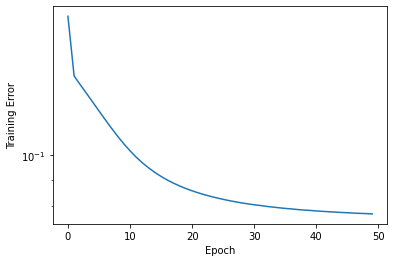

In [78]:
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [79]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id, uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [80]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), ncf)

In [81]:
test['in_recommendations'] = np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended)
test.in_recommendations.sum() / test.in_recommendations.size

0.25036689169357207

In [82]:
games_recommended = set()
np.vectorize(lambda curr_games, total: total.update(curr_games))(test.recommended, games_recommended)

array([None, None, None, ..., None, None, None], dtype=object)

In [83]:
len(games_recommended) / train.game_id.unique().size

0.34849951597289447